<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/3.%20Explainability%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import files
files.upload()
!pip install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

In [2]:
import os
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers, models, optimizers
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
import random as rn


In [4]:
breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/IDC_regular_ps50_idx5/10264/0/10264_idx5_x1651_y501_class0.png
/content/IDC_regular_ps50_idx5/10264/0/10264_idx5_x451_y2051_class0.png
/content/IDC_regular_ps50_idx5/10264/0/10264_idx5_x2101_y201_class0.png


In [5]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)

In [6]:
non_num = len(N_IDC)
can_num = len(P_IDC)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


In [35]:
import shutil

local_model_path = "/content/models"
if not os.path.exists(local_model_path):
  os.makedirs(local_model_path)
global_model_path = "/content/drive/My Drive/models/"
if not os.path.exists(global_model_path):
  os.makedirs(global_model_path)
global_model_path_report = "/content/drive/My Drive/report/"
if not os.path.exists(global_model_path_report):
  os.makedirs(global_model_path_report)

#Utility function

In [8]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)
set_seed()

In [9]:
def find_layer_index_by_name(model, layer_name):
    # This function retrieves the index of a layer with a given name
    # Arguments:
    # model -- The model to search in
    # layer_name -- The name of the layer to find
    # Returns:
    # The index of the layer with the given name, if found; otherwise, None

    # Iterate over the layers in the model and check if the current layer's name matches the given name
    for index, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return index  # Return the index of the layer with the given name

    # If no layer with the given name was found, return None
    return None


#Visualizing Intermediate Activations

Visualizing intermediate activations involves displaying the feature maps that are generated by different convolutional and pooling layers within a neural network when given a particular input. This process allows us to explore how the network processes information and learns to recognize patterns in the data. By observing the activations at different layers, we can gain insights into the hierarchical representation of information in the network and the features that it has learned to extract. This can help us to diagnose and fix problems with the network's performance, as well as to gain a deeper understanding of how the network works.

In [11]:
images_per_row = 16 # how many images per row to show

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

def get_conv_maxpool_layer_names_outputs(model):
    '''
    Restituisce i nomi e gli output dei livelli di convoluzione e max pooling del modello
    :param model: il modello da considerare
    :return: una tupla (layer_names, layer_outputs)
    '''
    layer_outputs = []
    layer_names = []
    for layer in model.layers:
        if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)
    return layer_names, layer_outputs

def print_intermediate_activations(layer_names, activations, num_layers_to_show=None, num_layers_to_skip=0, images_per_row=16):
    '''
    Stampa le attivazioni intermedie dei livelli di convoluzione e max pooling
    :param layer_names: i nomi dei livelli
    :param activations: i valori delle attivazioni dei livelli di convoluzione e max pooling
    :param num_layers_to_show: il numero di livelli da visualizzare
    :param num_layers_to_skip: il numero di livelli da saltare prima di iniziare la visualizzazione
    :param images_per_row: il numero di immagini per riga da visualizzare
    '''
    layer_names = layer_names[num_layers_to_skip:]
    activations = activations[num_layers_to_skip:]

    num_layers = len(layer_names)
    if num_layers_to_show and num_layers_to_show < num_layers:
        num_layers = num_layers_to_show

    for i in range(num_layers):
        layer_name = layer_names[i]
        layer_activation = activations[i]

        # Numero di features nella mappa di attivazione
        num_features = layer_activation.shape[-1]

        # La mappa di attivazione ha la forma (1, altezza_immagine, larghezza_immagine, num_features)
        # ma altezza_immagine = larghezza_immagine
        size = layer_activation.shape[1]

        num_cols = num_features // images_per_row
        display_grid = np.zeros((size * num_cols, images_per_row * size))

        for col in range(num_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean() # rimuove la media
                channel_image /= channel_image.std() # divide per la deviazione standard
                # ora abbiamo una distribuzione normale standard con il 95% dei valori dei pixel nell'intervallo [-2,2]
                # moltiplichiamo per 64 per ottenere l'intervallo [-128, 128]
                channel_image *= 64
                # ora possiamo sommare 128 per ottenere l'intervallo [0, 255]
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        # Mostra la griglia
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
    plt.show()


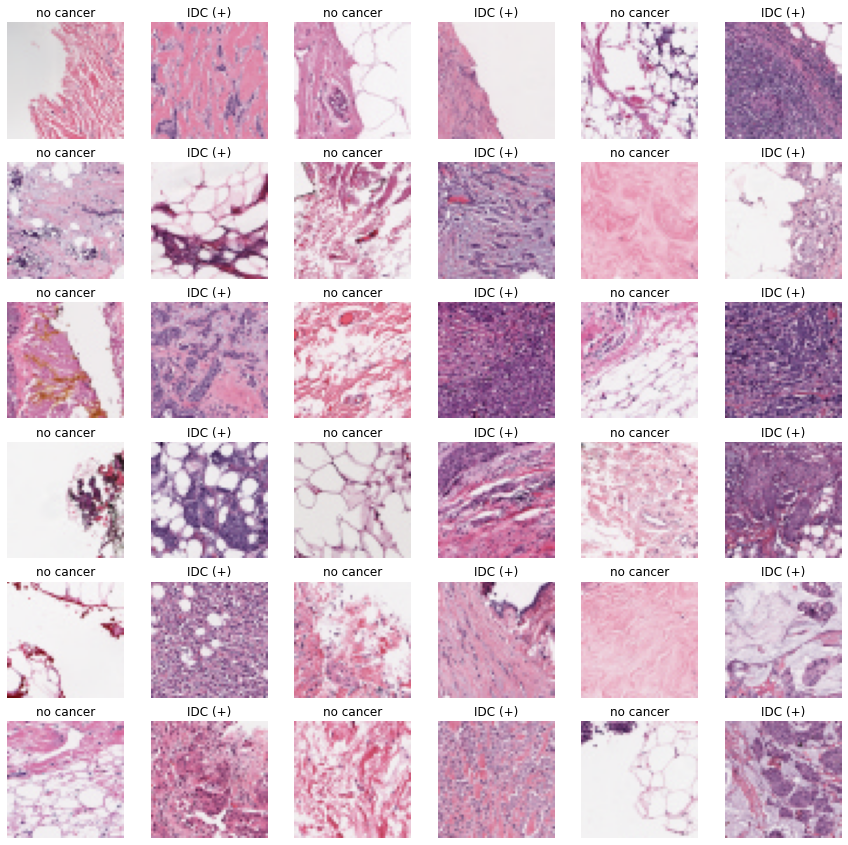

In [58]:
from keras.preprocessing import image
from PIL import Image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = Image.open((N_IDC[num]))
        img = img.resize((50, 50), Image.ANTIALIAS)
        img = np.array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = Image.open((P_IDC[num]))
        img = img.resize((50, 50), Image.ANTIALIAS)
        img = np.array(img)
        
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1        

In [60]:
img = np.expand_dims(img, axis=0) 

## CNN from scratch
Analyze the best CNN from scratch found.

In [59]:
model = "from_scratch/MoreLayers.h5"
model = model = tf.keras.models.load_model(f'{global_model_path}{model}')
model.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128 

To obtain the specific feature maps that we are interested in, we will construct a model that accepts batches of images as input and generates the activations of all convolutional and pooling layers as output.

In [61]:
layer_names, layer_outputs = get_conv_maxpool_layer_names_outputs(model)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) # one input and multiple outputs
activations = activation_model.predict(img)
for out in activations:
  print(out.shape)

1/1 [==============================] - 0s 114ms/step
(1, 50, 50, 32)
(1, 50, 50, 32)
(1, 25, 25, 32)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 12, 12, 64)
(1, 12, 12, 128)


<ipython-input-14-54ee2a364082>:53: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std() # divide per la deviazione standard


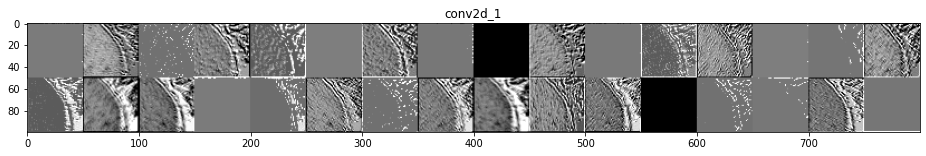

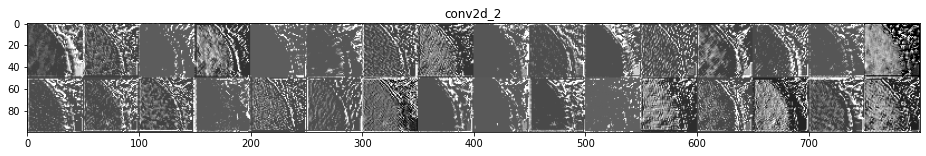

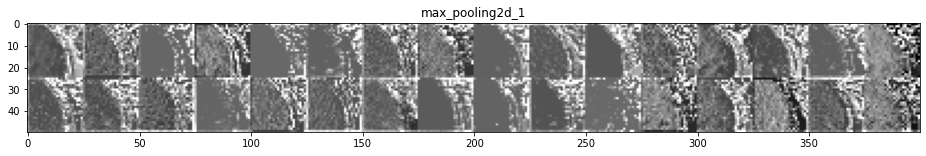

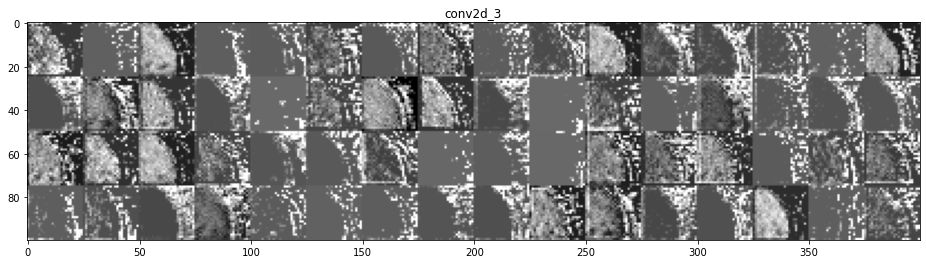

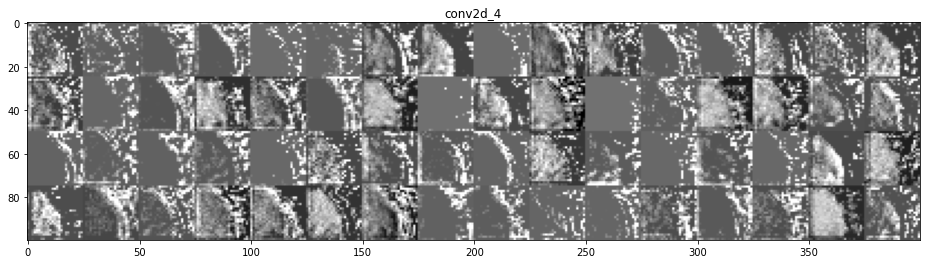

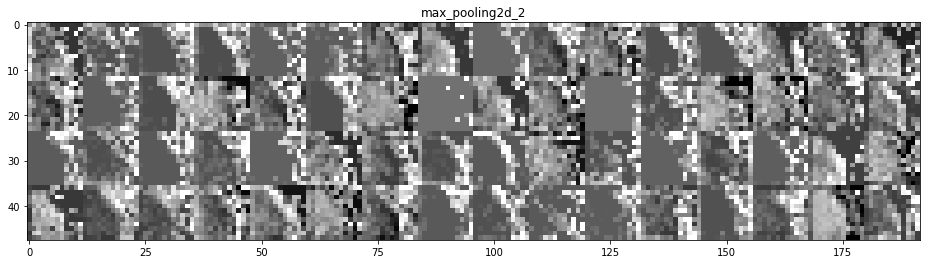

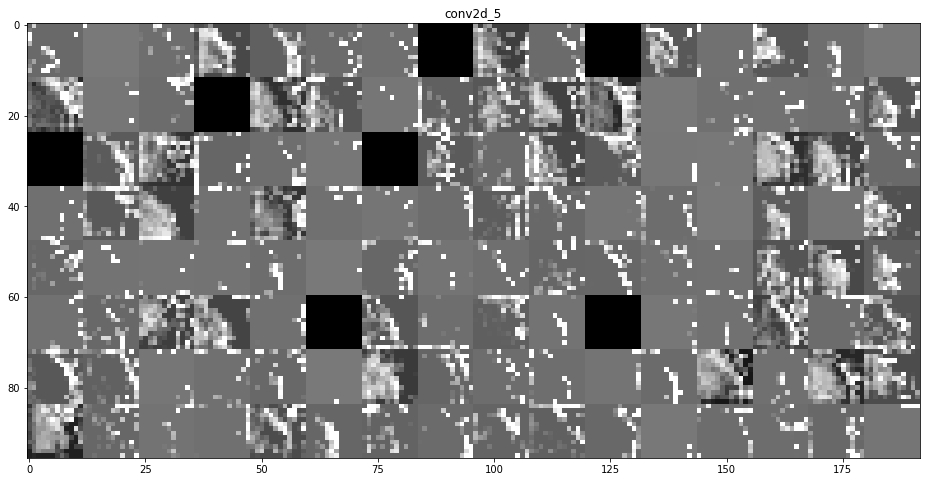

In [52]:
print_intermediate_activations(layer_names, layer_names)

# Pre-trained model with VGG16

In [62]:
model = "vgg16/AllLevelsUnlocked_CLAHE.h5"
model = model = tf.keras.models.load_model(f'{global_model_path}{model}')
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

In [65]:
model = model.get_layer('sequential_1') # focus only on the sequential_1 network, in which there are conv layers

In [66]:
layer_names, layer_outputs = get_conv_maxpool_layer_names_outputs(model)
print('How many layers: ', len(layer_names))
print(layer_names)
print(layer_outputs)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) # one input and multiple outputs
activations = activation_model.predict(img)
for out in activations:
  print(out.shape)

How many layers:  14
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool']
[<KerasTensor: shape=(None, 50, 50, 64) dtype=float32 (created by layer 'block1_conv1')>, <KerasTensor: shape=(None, 50, 50, 64) dtype=float32 (created by layer 'block1_conv2')>, <KerasTensor: shape=(None, 25, 25, 64) dtype=float32 (created by layer 'block1_pool')>, <KerasTensor: shape=(None, 25, 25, 128) dtype=float32 (created by layer 'block2_conv1')>, <KerasTensor: shape=(None, 25, 25, 128) dtype=float32 (created by layer 'block2_conv2')>, <KerasTensor: shape=(None, 12, 12, 128) dtype=float32 (created by layer 'block2_pool')>, <KerasTensor: shape=(None, 12, 12, 256) dtype=float32 (created by layer 'block3_conv1')>, <KerasTensor: shape=(None, 12, 12, 256) dtype=float32 (created by layer 'block3_conv2')>, <KerasTensor: shape=(None, 12, 12, 256) dt

1/1 [==============================] - 1s 568ms/step
(1, 50, 50, 64)
(1, 50, 50, 64)
(1, 25, 25, 64)
(1, 25, 25, 128)
(1, 25, 25, 128)
(1, 12, 12, 128)
(1, 12, 12, 256)
(1, 12, 12, 256)
(1, 12, 12, 256)
(1, 6, 6, 256)
(1, 6, 6, 512)
(1, 6, 6, 512)
(1, 6, 6, 512)
(1, 3, 3, 512)


<ipython-input-14-54ee2a364082>:53: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std() # divide per la deviazione standard


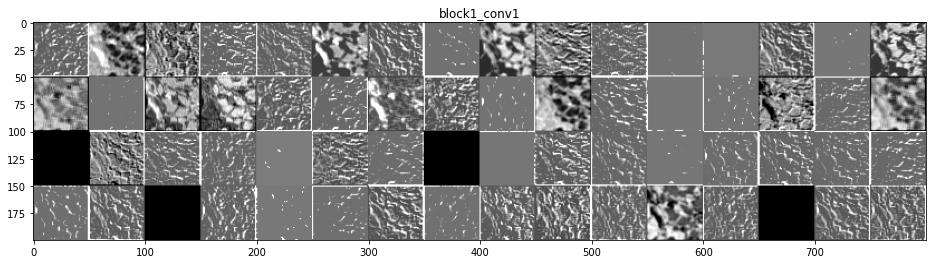

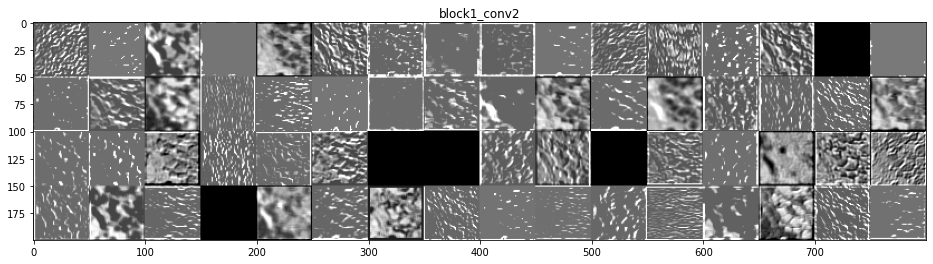

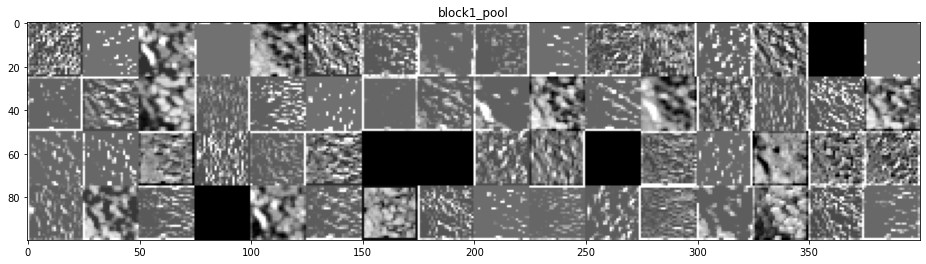

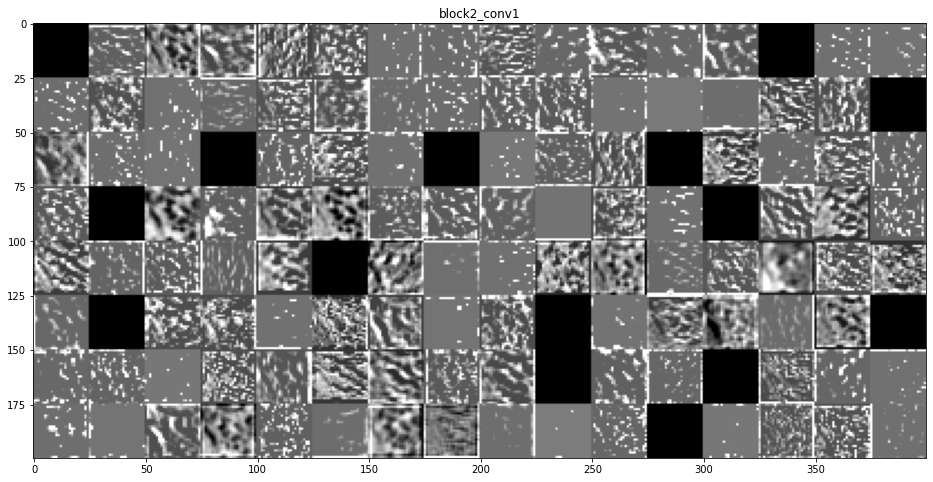

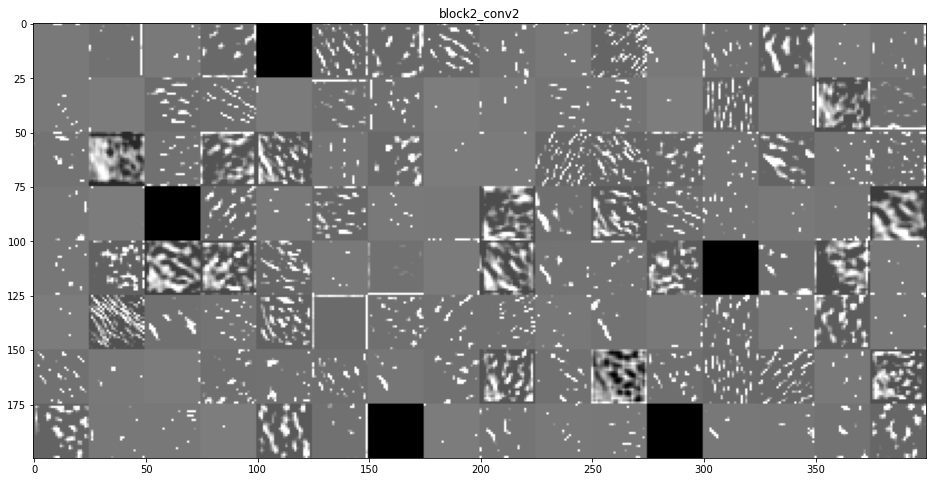

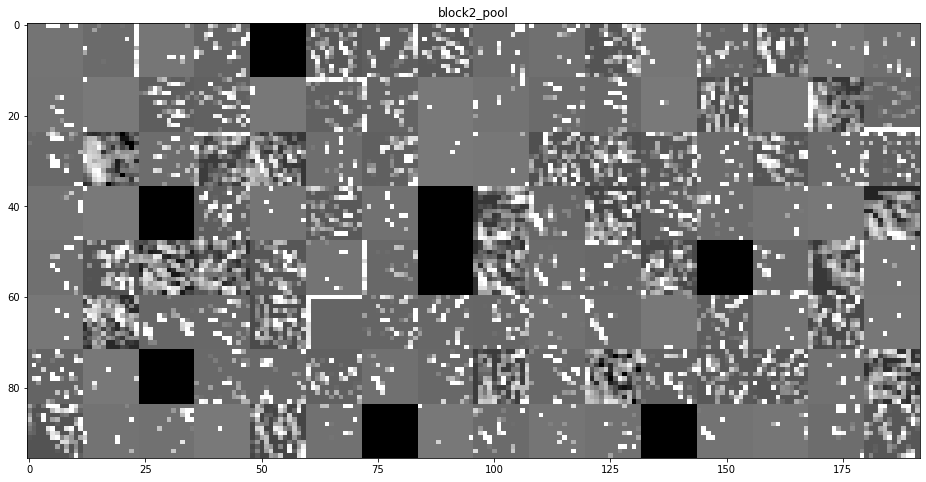

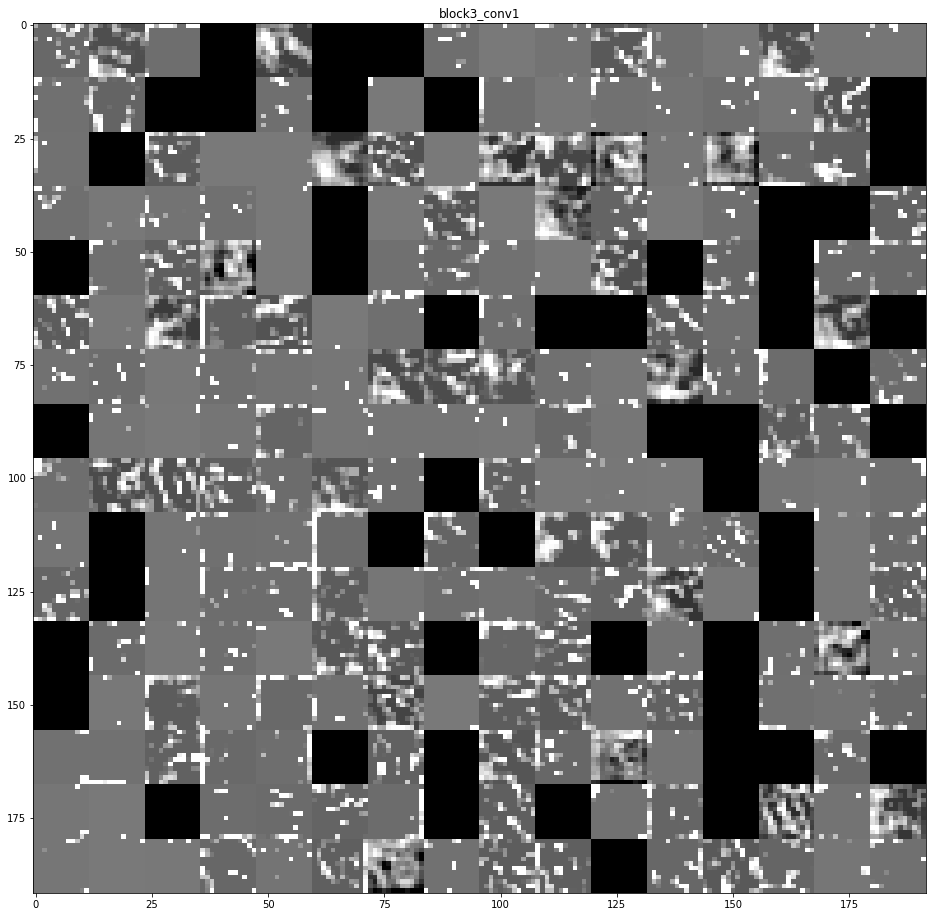

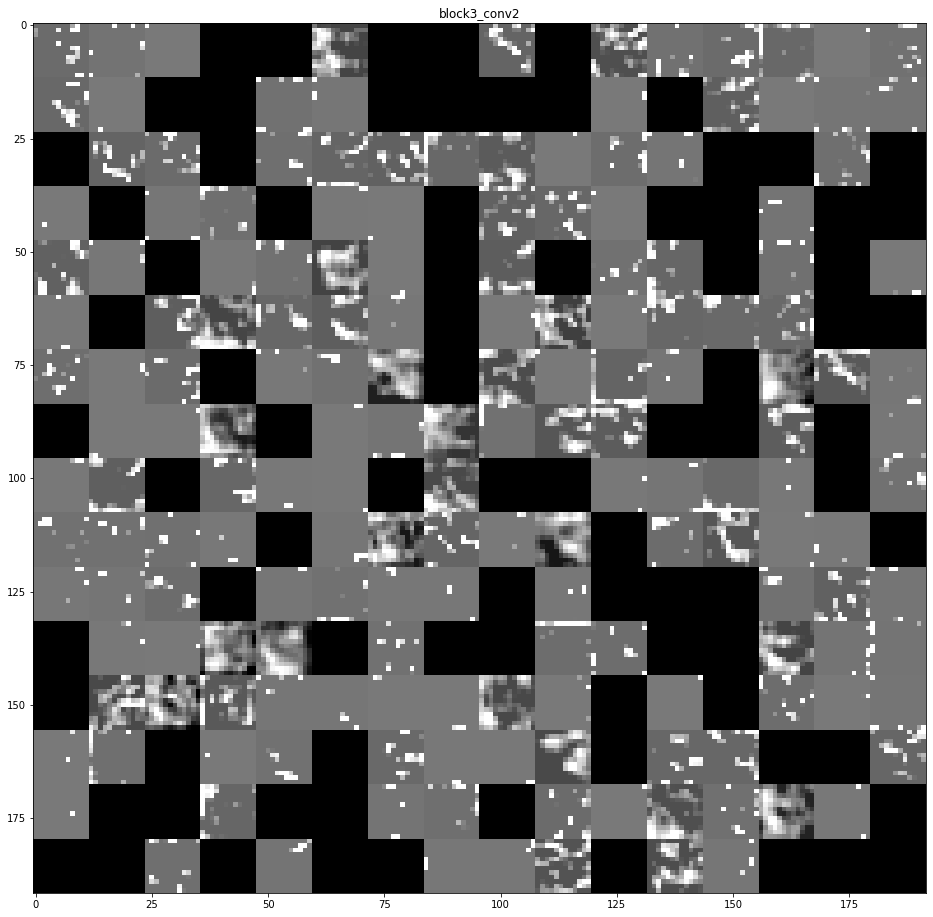

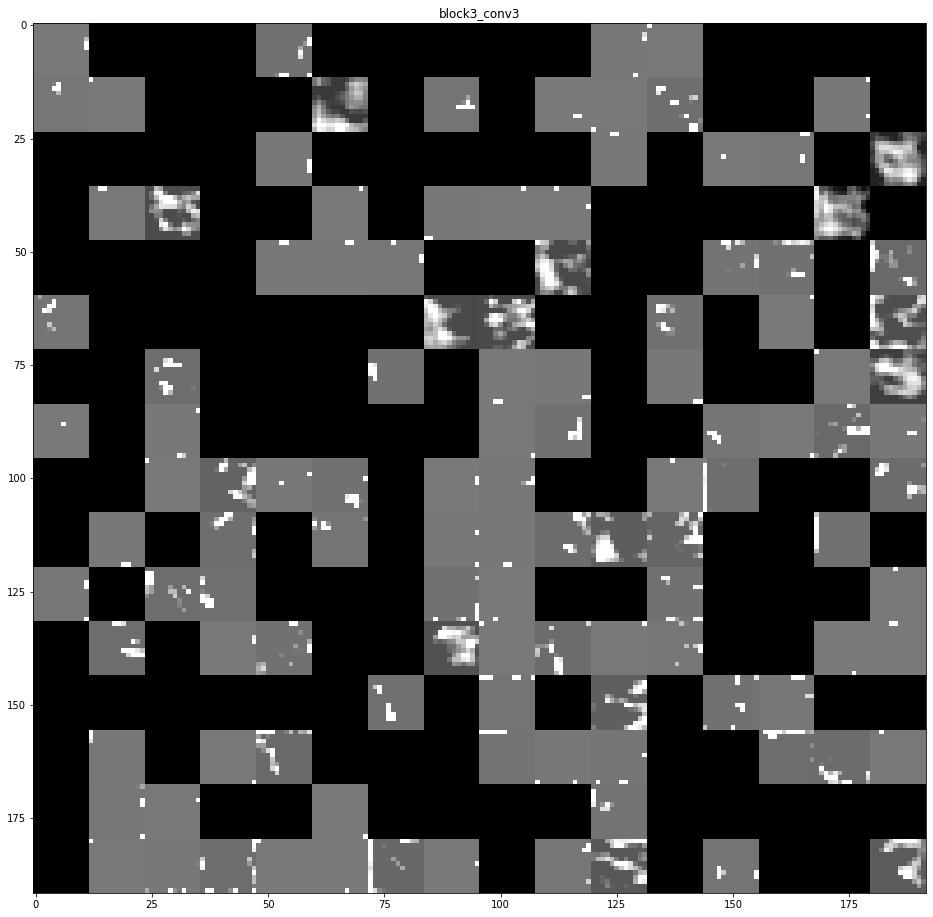

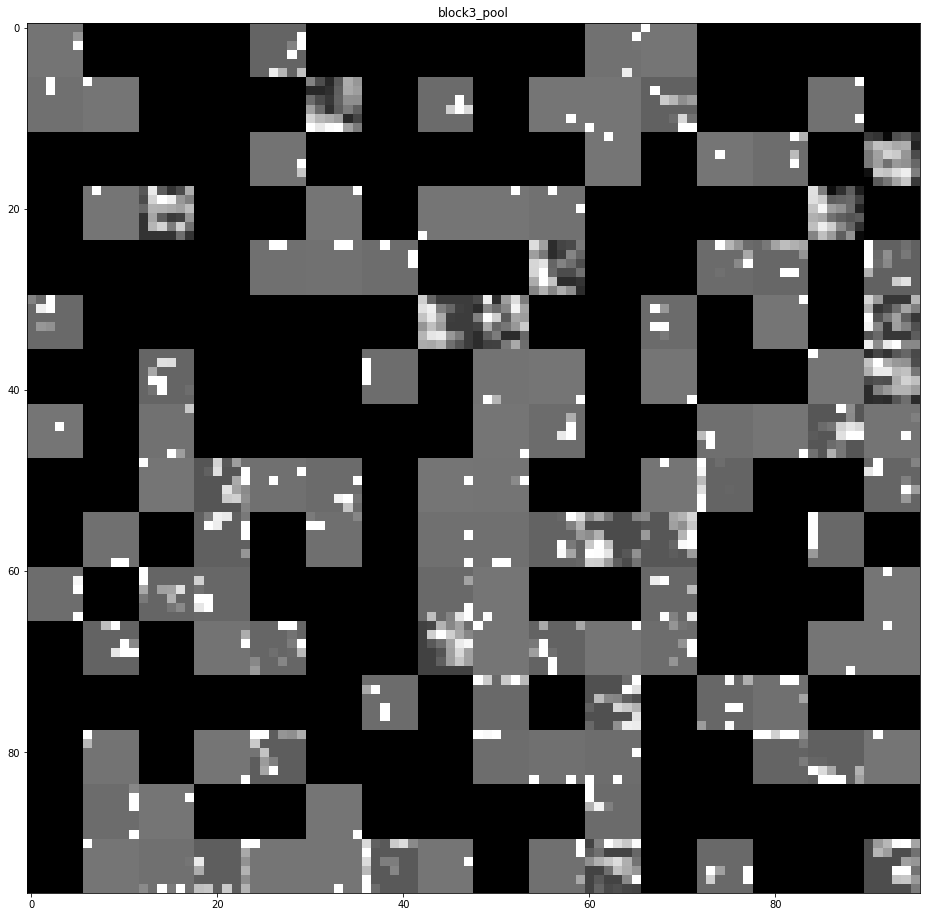

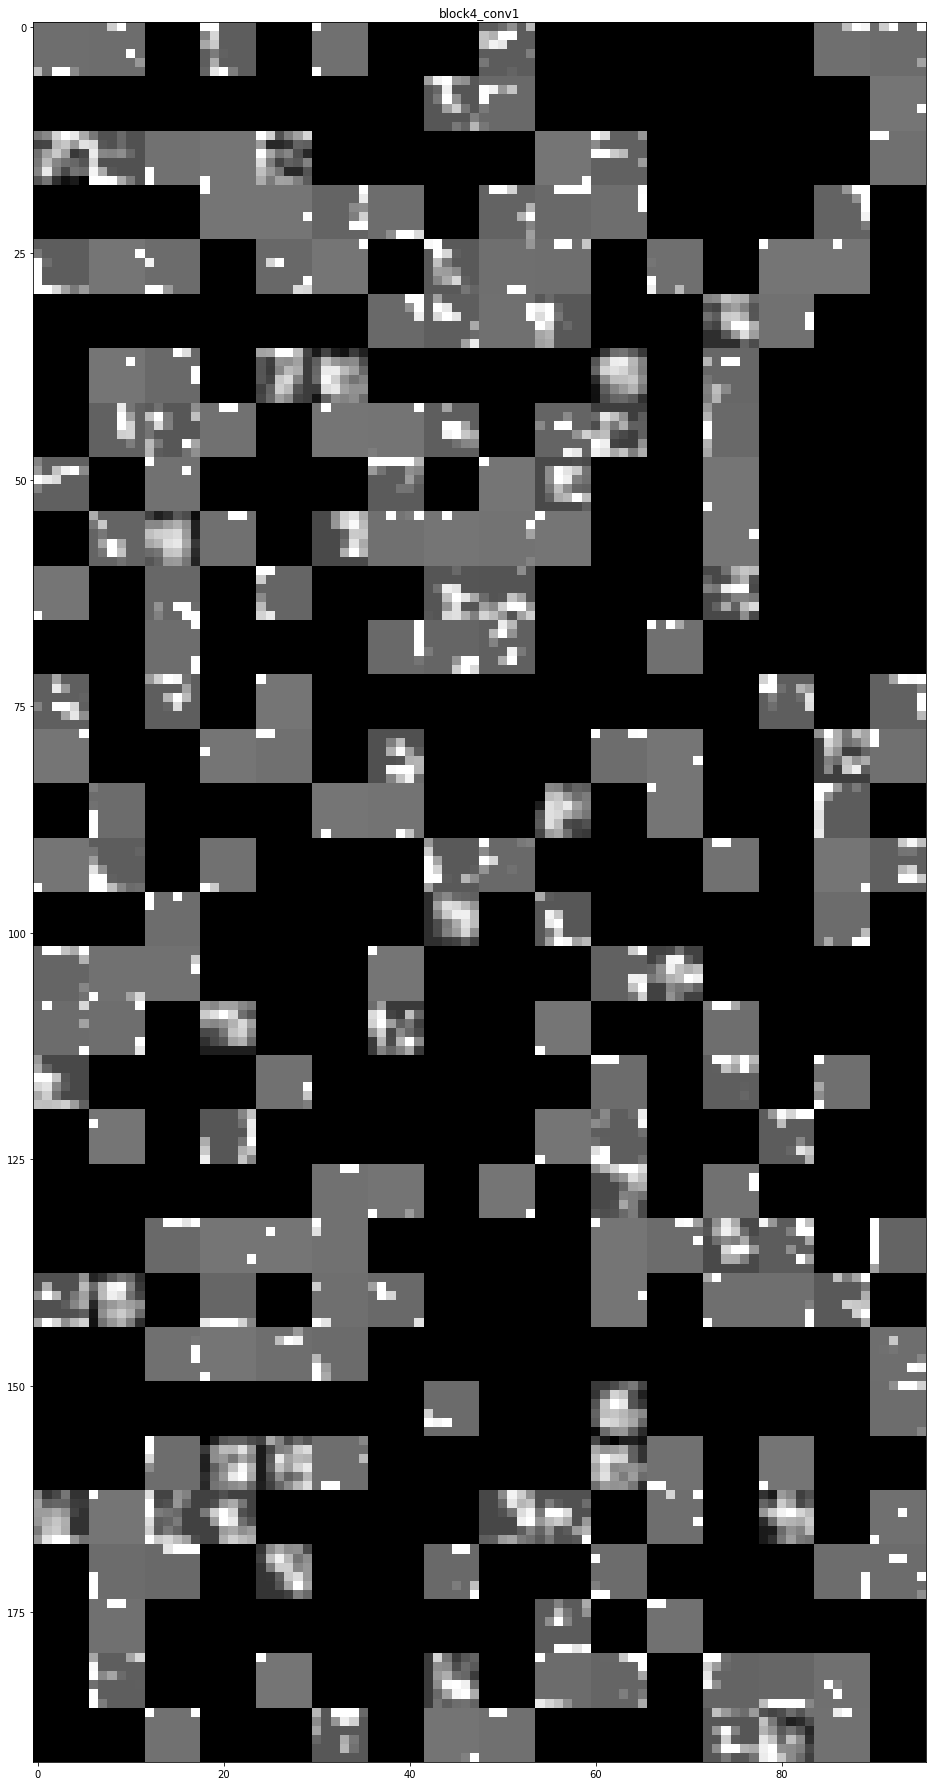

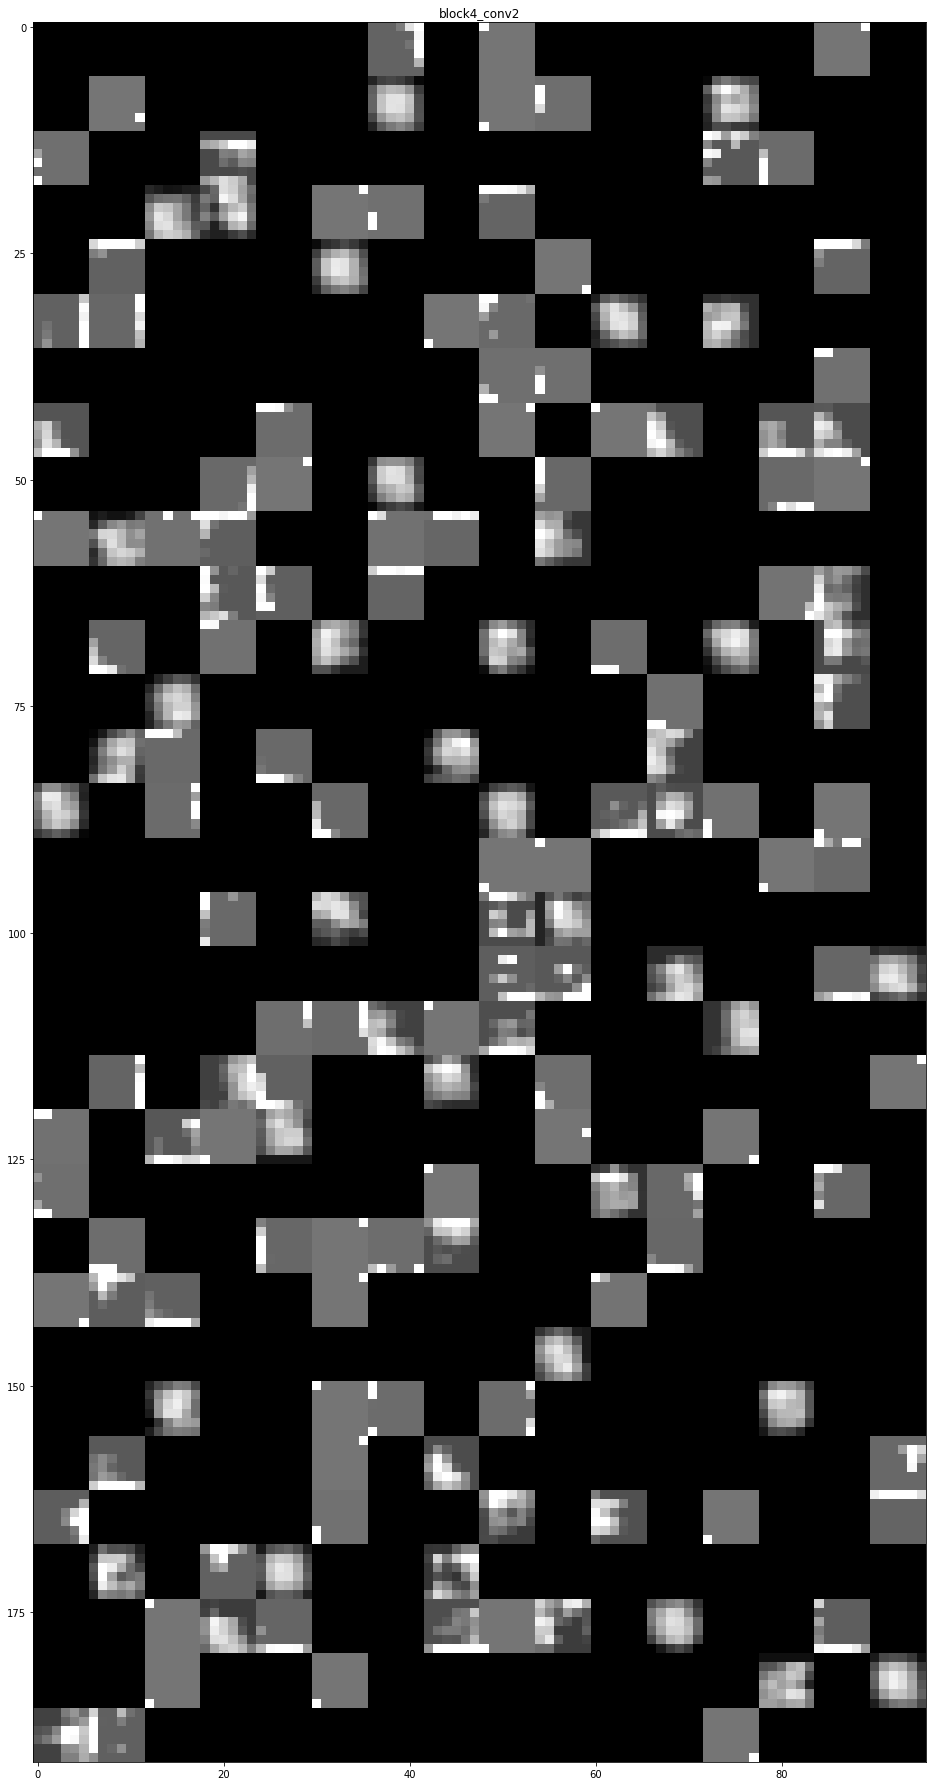

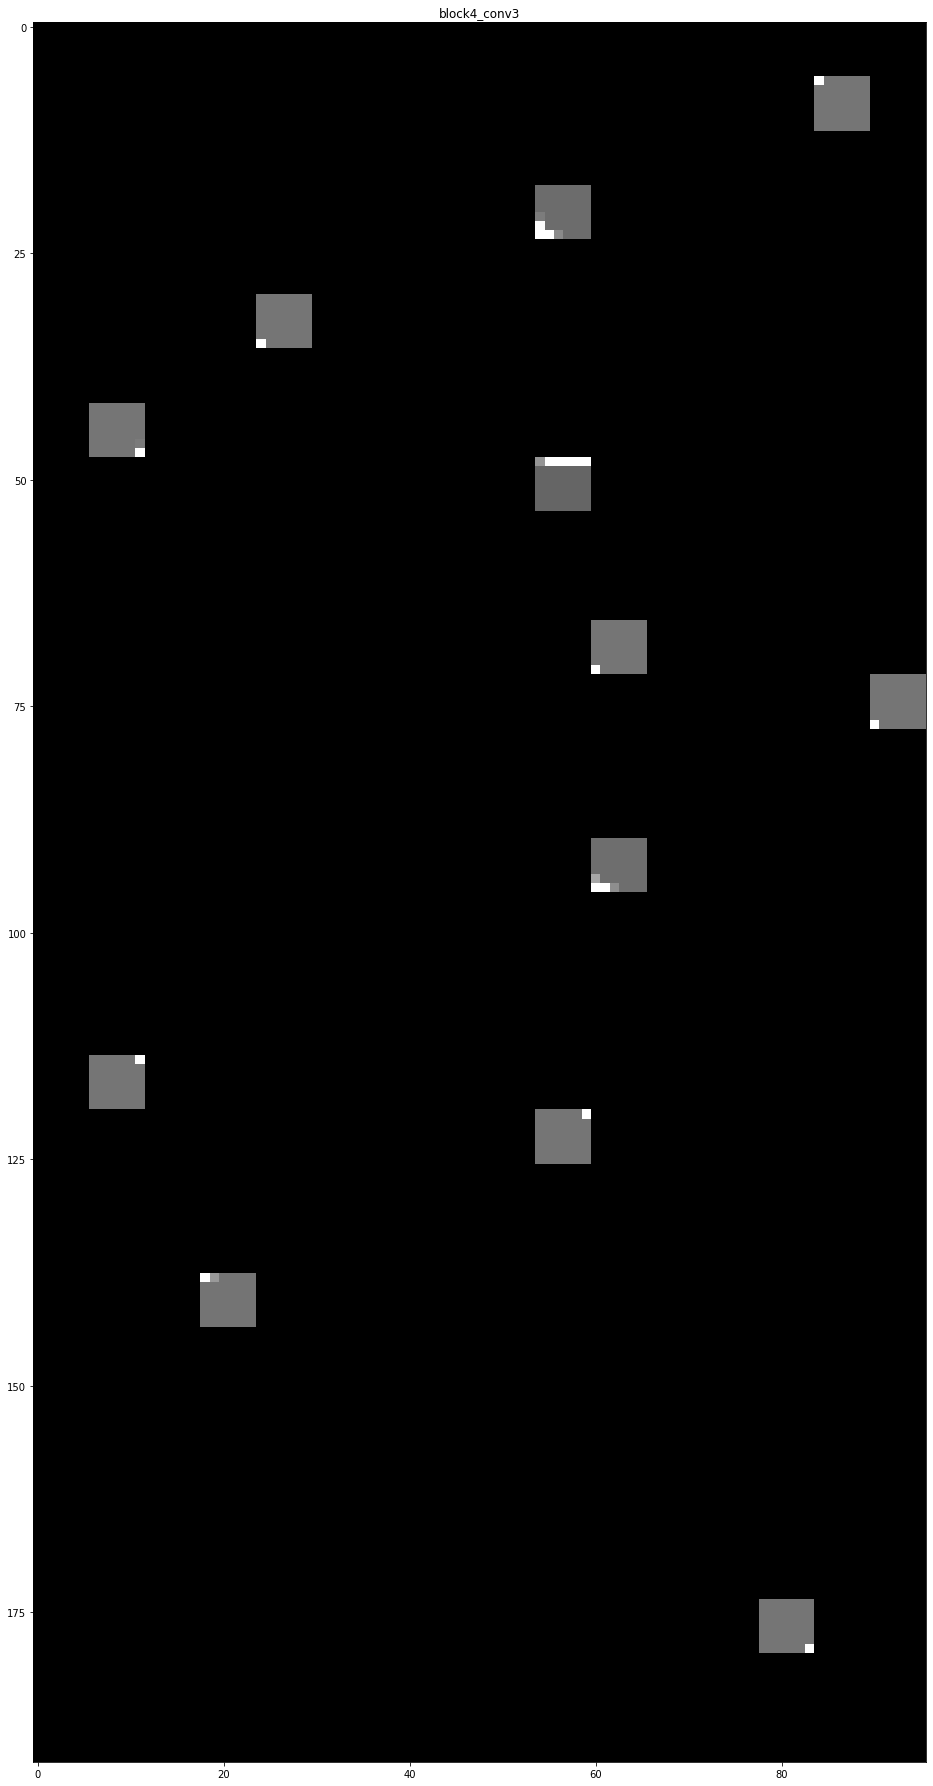

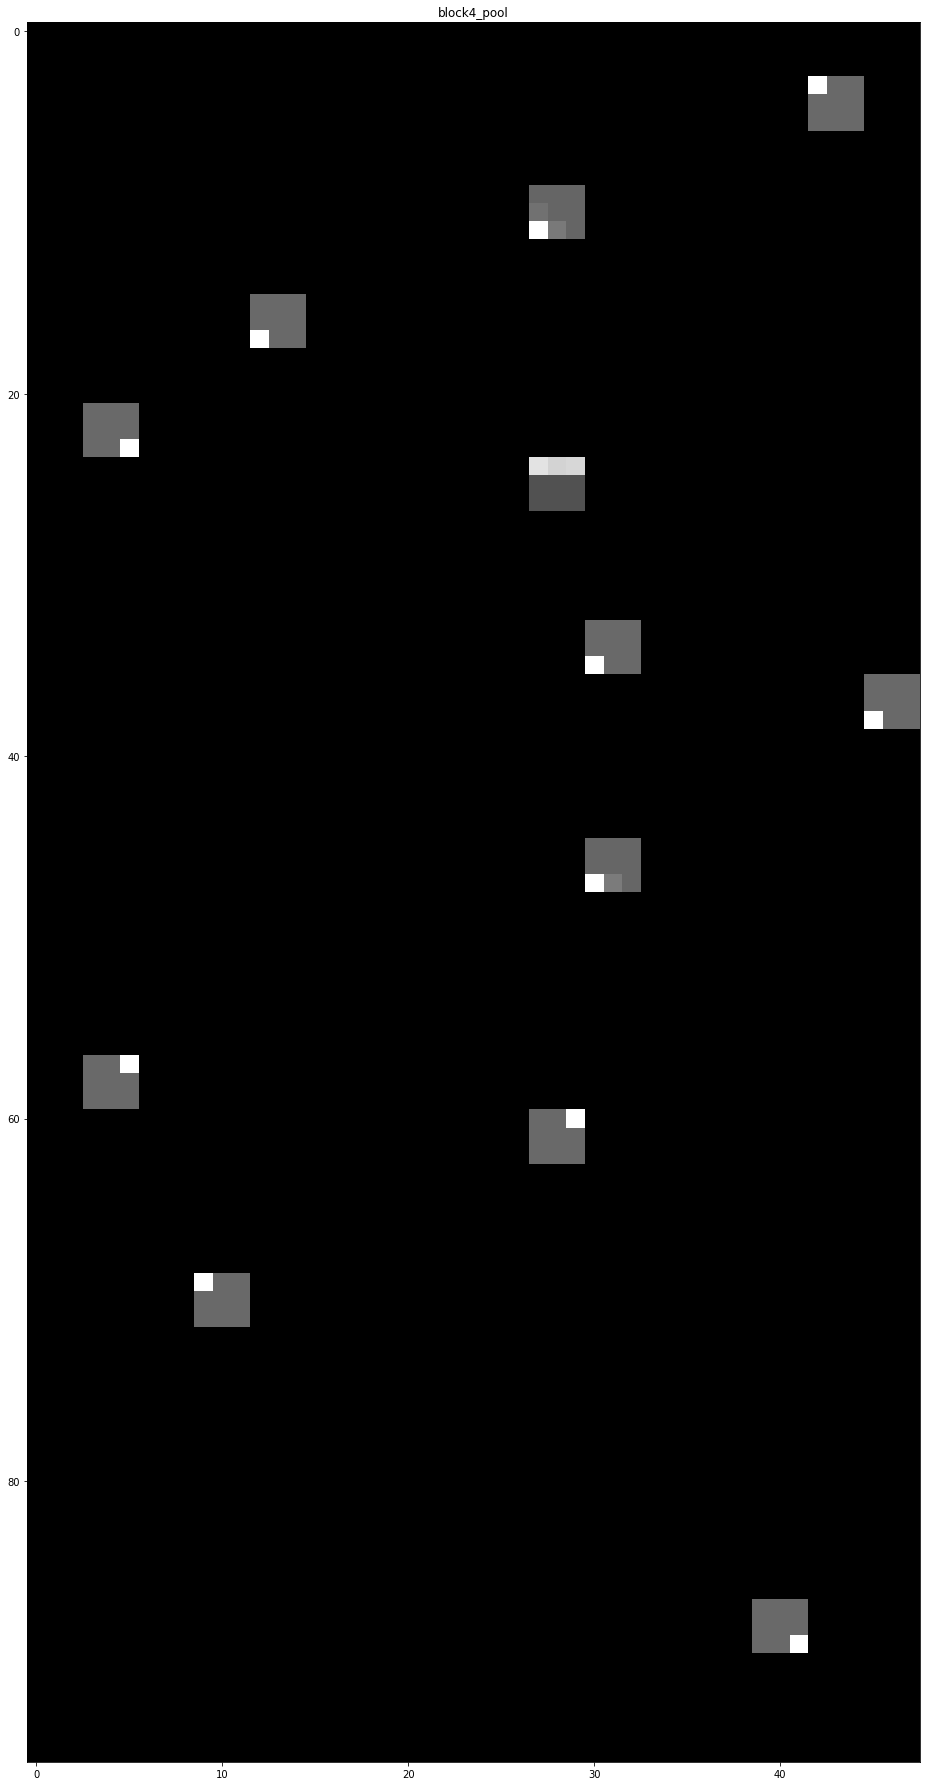

In [69]:
print_intermediate_activations(layer_names, activations)